In [1]:
  import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

###数据导入和处理


In [0]:
from numpy import genfromtxt
import numpy as np
my_data1 = genfromtxt('EMG_1ac10sec_MAT1-12.csv', delimiter=',')
my_data2 = genfromtxt('EMG_1ac10sec_MAO4-12.csv', delimiter=',')
my_data3 = genfromtxt('EMG_1ac10sec_MAT3-12.csv', delimiter=',')
my_data4 = genfromtxt('EMG_1ac10sec_MAT4-12.csv', delimiter=',')
my_data5 = genfromtxt('EMG_1ac10sec_MAO5-12.csv', delimiter=',')
my_data = np.concatenate((my_data1,my_data2,my_data3,my_data4,my_data5),axis=1)



#####每stepsize个连续的原始数据组成一个时间子序列，允许每两个label边界处两个label划分到一个子序列的情况(该方法的好处是：将多个数据集concatenate到一起后更容易做切片操作),然后将每个子序列(子序列长度为stepsize)作为新的example输入到 LSTM 中。

In [3]:
stepsize=30

data = my_data[1:10]
mydata = data.T
len_d=mydata.shape[0]     #length of data
print(len_d/stepsize)
num_s=int(len_d/stepsize) #number of subsequence
data=np.ndarray((num_s,stepsize,9))
i = 0
while i < num_s:
  while mydata[i*stepsize,8] != mydata[stepsize*(i+1)-1,8]:
      mydata = np.delete(mydata,i*stepsize,axis=0)  #Delete a part of data to make each group of data is pure
      len_d = mydata.shape[0]
      num_s = int(len_d/stepsize) #update the number of subsequence
  for j in range(stepsize):
    for k in range(9):
      data[i,j,k] = mydata[stepsize*i+j,k]
  i += 1
data=data[:num_s,:,:]    #num_s is updated
print(data.shape)


8028.866666666667
(7989, 30, 9)


Data Splitting

In [4]:
#Here we shuffle data
np.random.seed(0)
np.random.shuffle(data)
features=data[:,:,0:8]
label=data[:,:,8:9]-1
#label=np.reshape(label,(label.shape[0]*label.shape[1],1))
print("original shape: {0}".format(features.shape))

length =features.shape[0]
train_x = features[0:int(length*0.7), :,:]
train_y = label[0:int(length*0.7),0, :]
dev_x = features[int(length*0.7):int(length*0.9),:,:]
dev_y = label[int(length*0.7):int(length*0.9),0,:]
test_x=features[int(length*0.9):,:,:]
test_y=label[int(length*0.9):,0,:]
print(train_y.shape)

original shape: (7989, 30, 8)
(5592, 1)


label的格式要和model要求的格式吻合，但是onehot之后的是二维数据，需要用reshape扩维;
Onehot的使用方法：使用sklearn库的LabelBinarizer方法进行 fit_transform,前提是数据本身得是 2 维的，如果维数不合适可在fit_transform之后使用numpy.reshape方法进行维数变换

Label Binarizer

In [5]:
from sklearn.preprocessing import LabelBinarizer
label_encoder=LabelBinarizer()
y_train=label_encoder.fit_transform(train_y)
y_val=label_encoder.fit_transform(dev_y)
y_test=label_encoder.fit_transform(test_y)
# y_train=np.reshape(y_train,(int(y_train.shape[0]),1,y_train.shape[1]))
# y_val=np.reshape(y_val,(int(y_val.shape[0]),1,y_val.shape[1]))
# y_test=np.reshape(y_test,(int(y_test.shape[0]),1,y_test.shape[1]))
print("The shape after one-hot:{0}".format(y_test.shape))

onehot之后的shape:(799, 12)


## Building network

For this reason we will use larger layers. Let's go with 64 units:

In [0]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
model = models.Sequential()
model.add(layers.LSTM(64,input_shape=(stepsize,8),activation='relu',return_sequences=True,dropout=0))
# model.add(layers.LSTM(64, activation='relu',return_sequences=True))
model.add(layers.LSTM(32, activation='relu',return_sequences=True,dropout=0))
model.add(layers.LSTM(16, activation='relu',dropout=0))
model.add(layers.Dense(12, activation='softmax'))
epoch = 70
learning_rate = 0.001
decay_rate = learning_rate / epoch
adam = optimizers.Adam(lr=learning_rate, decay=0)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Set checkpoints to save the best model

In [0]:
from keras.callbacks import ModelCheckpoint
import os
import argparse
fname = "weights.best.hdf5"
checkpoint = ModelCheckpoint(fname,monitor="val_acc",mode="max", save_best_only=True,verbose=1)
callbacks = [checkpoint]

## Validating our approach


Now let's train our network using grid search:

In [16]:
history = model.fit(train_x, y_train, epochs=epoch, 
                    batch_size=30, validation_data=(dev_x, y_val),callbacks=callbacks)

Train on 5592 samples, validate on 1598 samples
Epoch 1/70
5592/5592 [==============================] - 15s 3ms/step - loss: 2.2475 - acc: 0.1761 - val_loss: 1.9232 - val_acc: 0.2522

Epoch 00001: val_acc improved from -inf to 0.25219, saving model to weights.best.hdf5
Epoch 2/70
5592/5592 [==============================] - 12s 2ms/step - loss: 1.6882 - acc: 0.2947 - val_loss: 1.6274 - val_acc: 0.3605

Epoch 00002: val_acc improved from 0.25219 to 0.36045, saving model to weights.best.hdf5
Epoch 3/70
5592/5592 [==============================] - 12s 2ms/step - loss: 1.5035 - acc: 0.3872 - val_loss: 1.4514 - val_acc: 0.3849

Epoch 00003: val_acc improved from 0.36045 to 0.38486, saving model to weights.best.hdf5
Epoch 4/70
5592/5592 [==============================] - 12s 2ms/step - loss: 1.3592 - acc: 0.4499 - val_loss: 1.2943 - val_acc: 0.4681

Epoch 00004: val_acc improved from 0.38486 to 0.46809, saving model to weights.best.hdf5
Epoch 5/70
5592/5592 [==============================] -

Let's display its loss and accuracy curves:

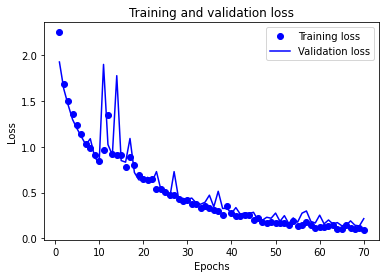

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

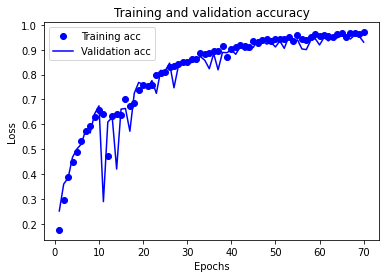

In [18]:
plt.clf()   # clear figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## TEST

In [19]:
y_test.shape

(799, 12)

In [20]:
#test_x=np.reshape(test_x,(test_x.shape[0],1,test_x.shape[1]))
#predictions = model.predict(test_x)
...
# evaluate the keras model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
model.load_weights('weights.best.hdf5')
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
_, accuracy = model.evaluate(test_x, y_test)
print('Stepsize: %d \nAccuracy: %.2f' % (stepsize,accuracy*100))


799/799 [==============================] - 1s 2ms/step
Stepsize: 30 
Accuracy: 95.74


In [21]:
y_pred = model.predict(test_x)
print(y_test.shape)

accuracy = accuracy_score(y_test,y_pred.round())
matrix = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
print('Accuracy: %.2f' % (accuracy*100))
print('Confusion Matrix:\n%s'%(matrix))

(799, 12)
Accuracy: 95.74
Confusion Matrix:
[[57  0  0  0  0  0  1  0  0  0  1  1]
 [ 0 70  0  3  0  0  0  0  0  0  0  1]
 [ 0  0 55  0  0  0  1  0  1  0  0  0]
 [ 0  2  0 71  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 79  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 72  0  0  0  1  0  1]
 [ 0  0  0  0  0  2 67  0  0  0  3  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 65  0  0  0]
 [ 1  0  0  0  0  1  0  0  7 66  0  0]
 [ 1  0  0  0  0  0  0  0  2  0 55  0]
 [ 0  0  0  1  0  2  0  0  0  0  0 58]]
